# Example 2: Query multiple items using paging
See more about paging here: https://graphql.org/learn/pagination/

In [3]:
from srgssr_publication_data_api import PublicationDataApi
import os

## 1. Check the API endpoint and initialize client

In [5]:
%env PDP_API

'https://graphql-api.pdp.dev.srgssr.ch/graphql'

In [6]:
client = PublicationDataApi(os.environ['PDP_API'], os.environ['USER_NAME'], os.environ['USER_PASSWORD'])

## 2. Show available queries

In [8]:
# first=[number of queries to retrieve, e.g. *first* 10 queries]
# after=[id or cursor position from which to start]
client.schema.Query

type Query {
  faroItems(first: Int!, after: String): FaroItemPage!
}

## 3. Configure the query operation with paging
To query pages programmatically we parametrize the query

In [9]:
from sgqlc.types import Variable, non_null

op = client.query_op(name='faroItems', variables={'first':non_null(int), 'after':str})

In [10]:
# return current query (empty)
op

query faroItems($first: Int!, $after: String) {
}

In [11]:
# select query type and configure with argument
faro = op.faro_items(first=Variable('first'), after=Variable('after'))

In [12]:
# return current query (configured)
op

query faroItems($first: Int!, $after: String) {
  faroItems(first: $first, after: $after) {
    edges {
      id
      programId
      itemNr
      mediaUrns
      playLinks
      descriptorPaths
      title
      producer
      description
      descriptor
    }
    cursor
  }
}

## 4. Select fields of interest

In [24]:
# select fields to be retured
faro.edges.id()
faro.edges.program.date()
faro.edges.program.title()
faro.edges.producer()
faro.cursor()

cursor

In [25]:
# return current query
op

query faroItems($first: Int!, $after: String) {
  faroItems(first: $first, after: $after) {
    edges {
      id
      title
      producer
      program {
        date
        title
      }
    }
    cursor
  }
}

## 5. Retrieve the data

In [26]:
# constants
page_size = 100
page_requests = 100

In [27]:
# initialize with first query
data = client.run_query(op, {'first':page_size})

results = data.faro_items

if not results.edges:
    print('No items!', file=sys.stderr)
    raise SystemExit()

In [28]:
from tqdm.notebook import tnrange
for i in tnrange(page_requests, desc="Downloading data"):
    # query page
    data = client.run_query(op, {'first':page_size, 'after':results.cursor})
    
    # convert page to object oriented results
    page = data.faro_items

    # extract new edges and update cursor
    results.edges += page.edges
    results.cursor = page.cursor

In [29]:
print(f'INFO - Retrieved {len(results.edges):,} FaroItems')

INFO - Retrieved 10,100 FaroItems


## 6. Plot the year distribution of first display

In [30]:
from collections import Counter
from datetime import date

# count year occurrences
c = Counter(date.fromisoformat(x.program.date).year for x in results.edges if x.program.date)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

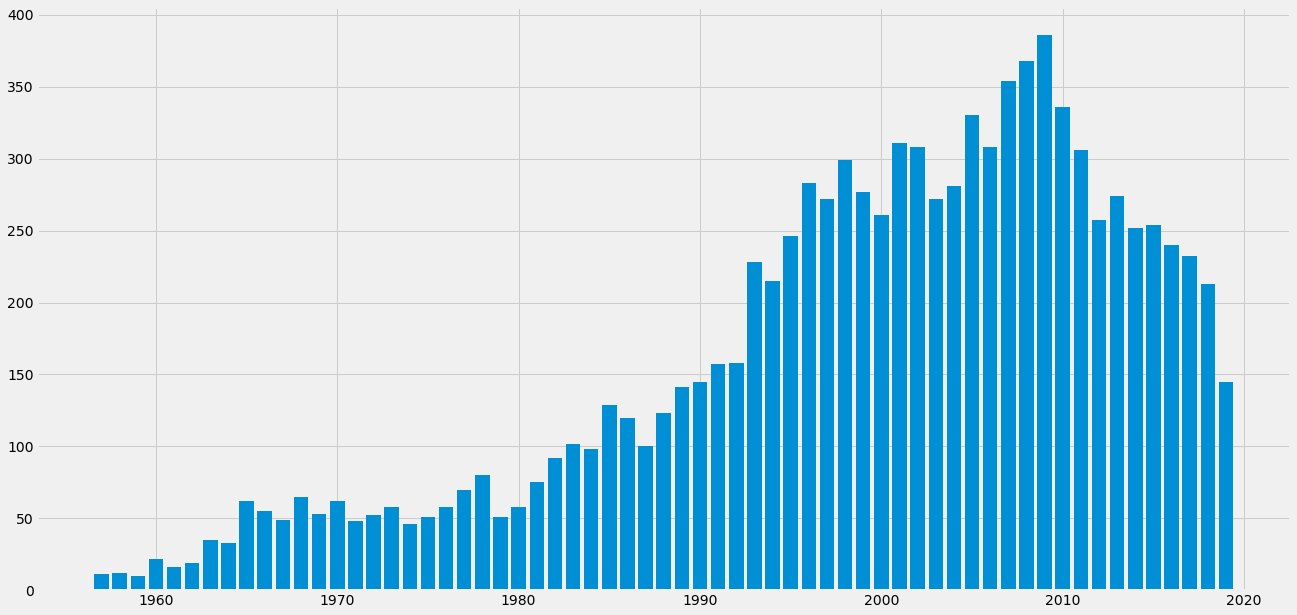

In [32]:
with plt.style.context('fivethirtyeight'):
    plt.bar(c.keys(), c.values())

## 7. Load data into a `pandas` dataframe

In [33]:
import pandas as pd

In [34]:
results.edges[0].__fields_cache__

OrderedDict([('id', id: String!),
             ('title', title: String),
             ('producer', producer: String),
             ('program', program: FaroProgram)])

In [35]:
# todo: find better way to import data into pandas
df = pd.DataFrame([x.__json_data__ for x in results.edges])

In [36]:
df

,id,title,producer,program
0,00000703-a68b-43fd-a7c4-796f464f4f69,EW Ferrera,TvR,"{'date': '1998-11-13', 'title': None}"
1,00003565-3733-4f67-8095-d1156c6c89f0,Gotthard-Basistunnel als Bauwerk der Superlative,SRF,"{'date': '2016-06-01', 'title': None}"
2,00005416-87ac-4d3f-a5a7-e4822ec929d4,Wahl Leuenberger,SF,"{'date': '2005-12-07', 'title': None}"
3,00007798-1a95-478b-9fd4-22b186cd281a,"Nationalpark-Serie \""Il parc naziunal svizzer\...",TvR,"{'date': '2008-05-26', 'title': None}"
4,0000ff71-0c57-4a24-898f-25b203aa0ad9,Puls-mix,SF,"{'date': '2007-02-26', 'title': None}"
...,...,...,...,...
10095,06ae60ac-b66a-4fd0-b136-15fe196fbba5,None,SRG,"{'date': '1981-09-06', 'title': None}"
10096,06ae6336-2681-4e15-9591-986b77114eaa,Miese Weinernte im Baselbiet,SRF,"{'date': '2017-10-24', 'title': None}"
10097,06ae7452-5304-46b9-8ede-1e4fbccc8922,AKW-Region Niederamt,SRF,"{'date': '2011-03-17', 'title': None}"
10098,06ae8fdd-fbaf-482a-a407-fe92a26700c5,None,DRS,"{'date': '1984-09-17', 'title': 'Ansprache Bun..."


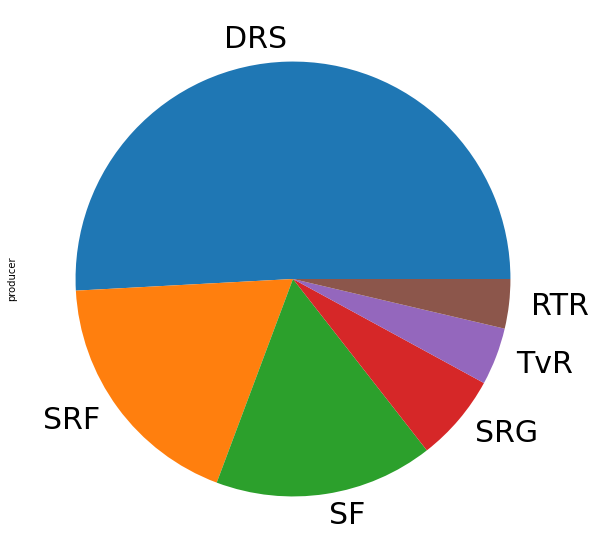

In [38]:
(df
 .groupby('producer')
 .filter(lambda x: len(x) > 100)
 .producer
 .value_counts()
 .plot
 .pie(fontsize=30));